In [17]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import Callback

In [4]:
pd.set_option('display.max_rows', 500)

In [5]:
def change_datatype(df):
    int8_vals = np.iinfo(np.int8)
    int16_vals = np.iinfo(np.int16)
    int32_vals = np.iinfo(np.int32)

    float16_vals = np.finfo(np.float16)
    float32_vals = np.finfo(np.float32)
    
    for col in df.columns:
        max_val = df[col].max()
        min_val = df[col].min()

        # print(f"{col}: max {max_val} -- min {min_val}")
        
        if df[col].dtype == np.int64:
            if max_val <= int8_vals.max and min_val >= int8_vals.min:
                df[col] = df[col].astype(np.int8)
            elif max_val <= int16_vals.max and min_val >= int16_vals.min:
                df[col] = df[col].astype(np.int16)
            elif max_val <= int32_vals.max and min_val >= int32_vals.min:
                df[col] = df[col].astype(np.int32)

        elif df[col].dtype == np.float64:
            if max_val <= float16_vals.max and min_val >= float16_vals.min:
                df[col] = df[col].astype(np.float16)
            elif max_val <= float32_vals.max and min_val >= float32_vals.min:
                df[col] = df[col].astype(np.float32)
    return df

In [6]:
csv_train = "./oversampling/NRAS_trainset.csv"
csv_test = "./raw/raw_testset.csv"

In [7]:
train_df = pd.read_csv(csv_train)
train_df = change_datatype(train_df)

train_df = train_df.drop('Unnamed: 0', axis = 1)

In [8]:
test_df = pd.read_csv(csv_test)
test_df = change_datatype(test_df)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9539966 entries, 0 to 9539965
Data columns (total 69 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             float32
 1   flow_duration                float32
 2   total_fwd_packets            float32
 3   total_backward_packets       float32
 4   total_length_of_fwd_packets  float32
 5   total_length_of_bwd_packets  float32
 6   fwd_packet_length_max        float16
 7   fwd_packet_length_min        float16
 8   fwd_packet_length_mean       float16
 9   fwd_packet_length_std        float16
 10  bwd_packet_length_max        float16
 11  bwd_packet_length_min        float16
 12  bwd_packet_length_mean       float16
 13  bwd_packet_length_std        float16
 14  flow_bytes_s                 float32
 15  flow_packets_s               float32
 16  flow_iat_mean                float32
 17  flow_iat_std                 float32
 18  flow_iat_max                 float32
 19  

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756690 entries, 0 to 756689
Data columns (total 69 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   destination_port             756690 non-null  int32  
 1   flow_duration                756690 non-null  int32  
 2   total_fwd_packets            756690 non-null  int32  
 3   total_backward_packets       756690 non-null  int32  
 4   total_length_of_fwd_packets  756690 non-null  int32  
 5   total_length_of_bwd_packets  756690 non-null  int32  
 6   fwd_packet_length_max        756690 non-null  int16  
 7   fwd_packet_length_min        756690 non-null  int16  
 8   fwd_packet_length_mean       756690 non-null  float16
 9   fwd_packet_length_std        756690 non-null  float16
 10  bwd_packet_length_max        756690 non-null  int16  
 11  bwd_packet_length_min        756690 non-null  int16  
 12  bwd_packet_length_mean       756690 non-null  float16
 13 

In [9]:
scaler = QuantileTransformer(
       n_quantiles = 10000,
       random_state = 6969,
       output_distribution = "uniform"
)

In [10]:
X_train = train_df.drop('label', axis = 1)
y_train = train_df['label']

X_test = test_df.drop('label', axis = 1)
y_test = test_df['label']

In [11]:
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [12]:
scaled_train_df = pd.DataFrame(X_train_scaler, columns = X_train.columns)

In [13]:
scaled_test_df = pd.DataFrame(X_test_scaler, columns = X_test.columns)

In [21]:
model = XGBClassifier(learning_rate = 0.01, n_estimators = 200, max_depth = 5, objective = 'multi:softmax')
history = model.fit(X_train, y_train)

d:\dataset\env\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
d:\dataset\env\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
d:\dataset\env\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
d:\dataset\env\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
d:\dataset\env\lib\site-packages\xgboost\

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

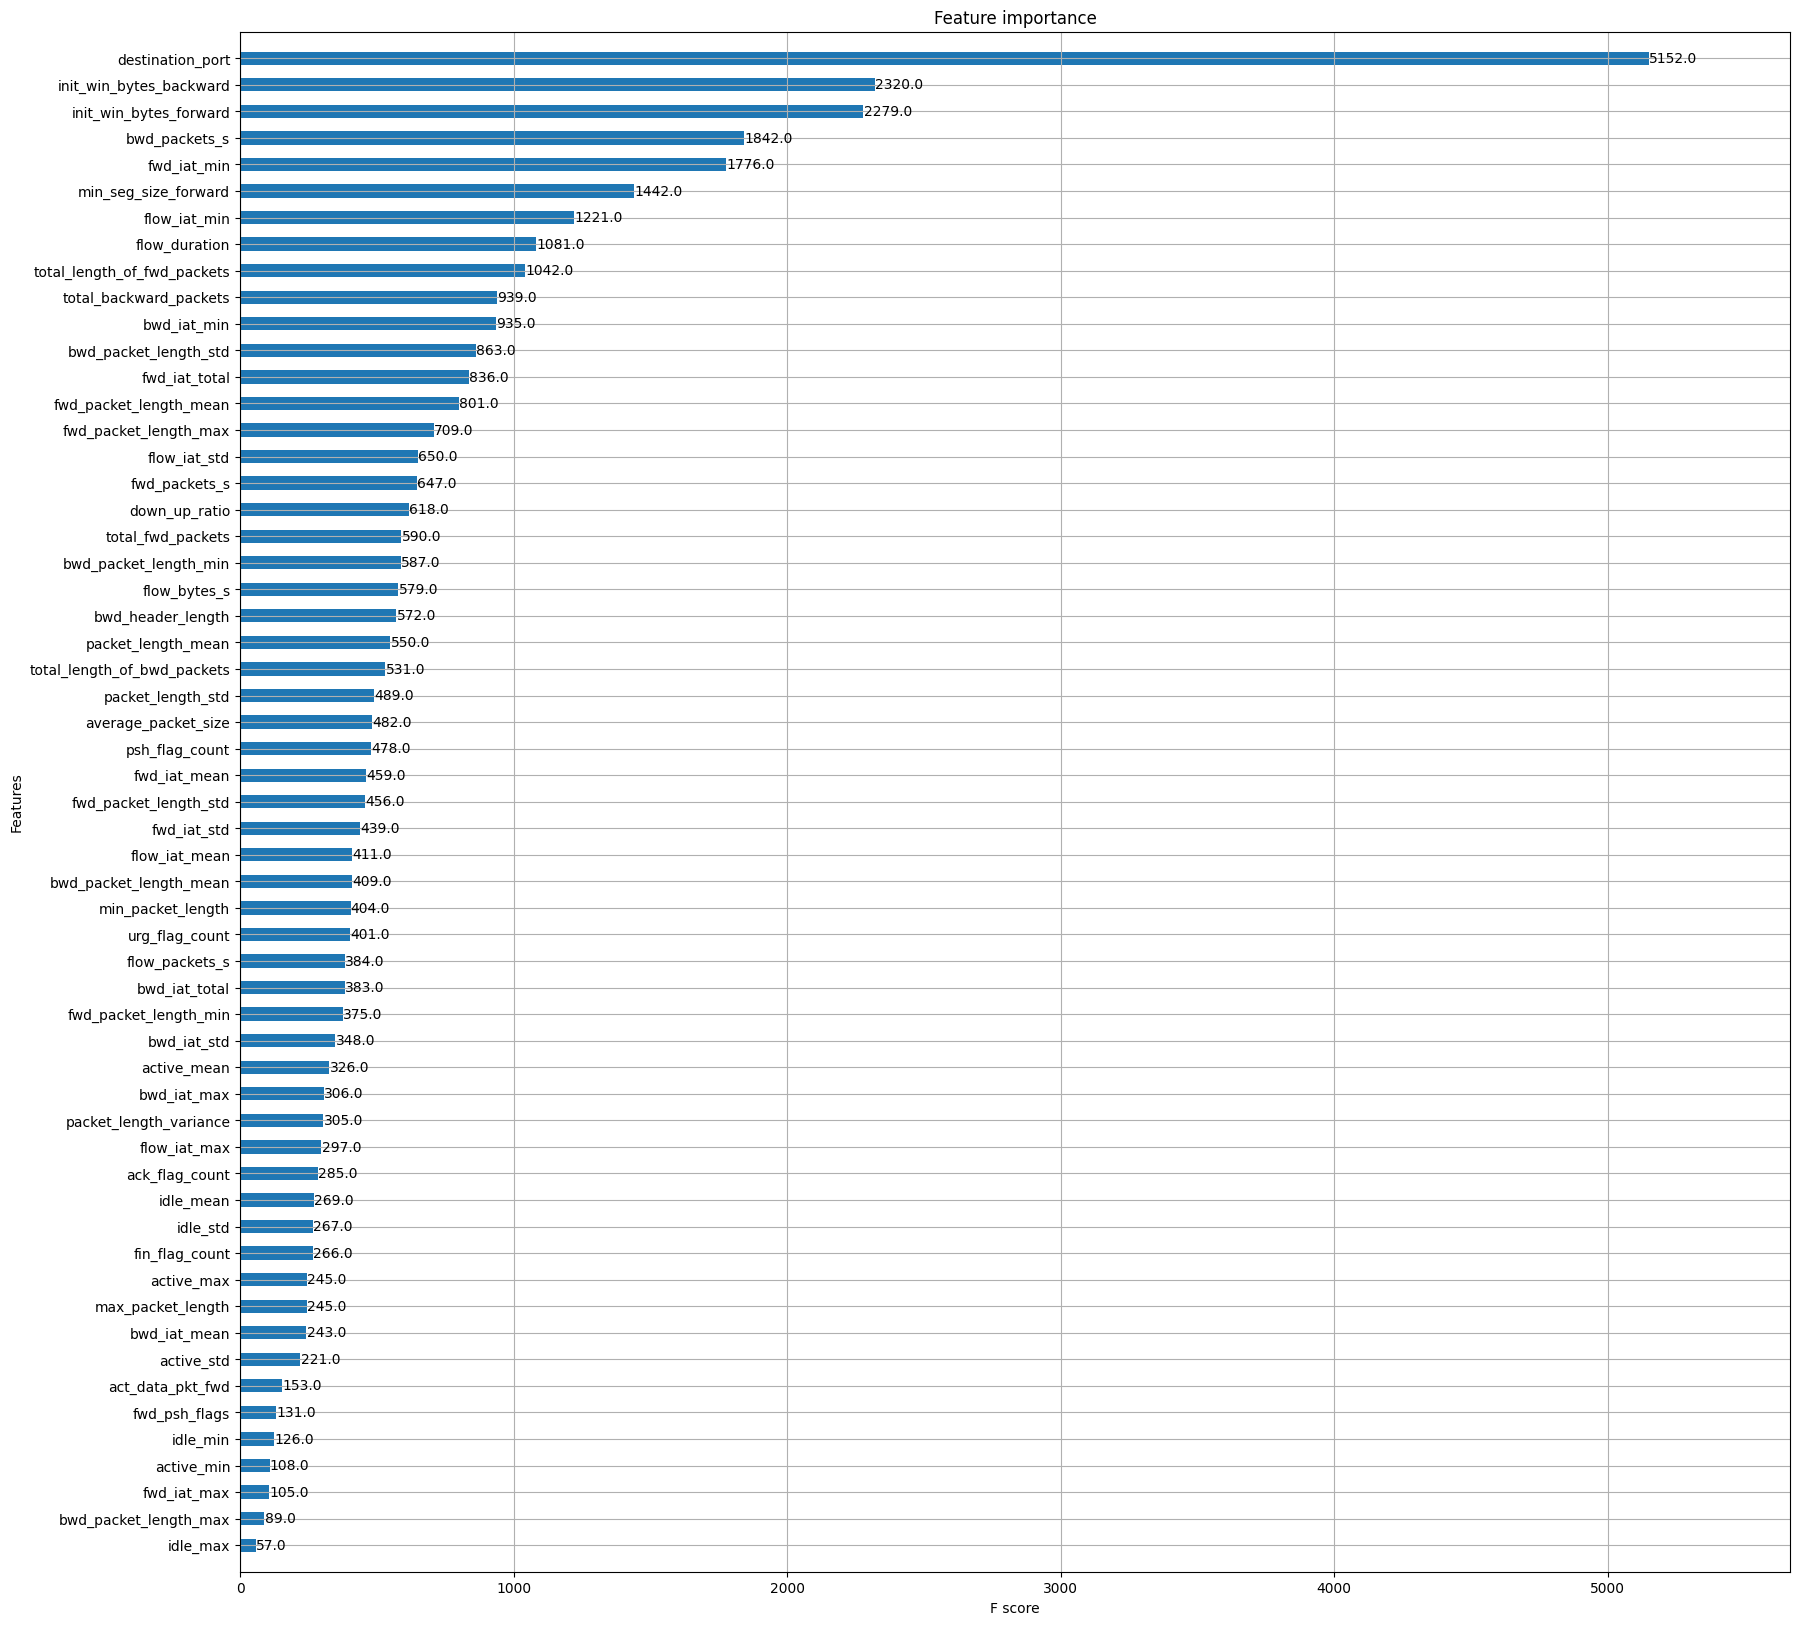

In [22]:
fig, ax = plt.subplots(figsize = (20, 20))
plot_importance(model, height = 0.5, ax = ax)

In [29]:
importance_feature_scores = model.get_booster().get_score(importance_type = "weight")
ranked = pd.Series(importance_feature_scores , index = X_train.columns).sort_values(ascending = False)

In [33]:
top_40_features = [f for f, v in ranked.items()][:40]
top_40_features

['destination_port',
 'init_win_bytes_backward',
 'init_win_bytes_forward',
 'bwd_packets_s',
 'fwd_iat_min',
 'min_seg_size_forward',
 'flow_iat_min',
 'flow_duration',
 'total_length_of_fwd_packets',
 'total_backward_packets',
 'bwd_iat_min',
 'bwd_packet_length_std',
 'fwd_iat_total',
 'fwd_packet_length_mean',
 'fwd_packet_length_max',
 'flow_iat_std',
 'fwd_packets_s',
 'down_up_ratio',
 'total_fwd_packets',
 'bwd_packet_length_min',
 'flow_bytes_s',
 'bwd_header_length',
 'packet_length_mean',
 'total_length_of_bwd_packets',
 'packet_length_std',
 'average_packet_size',
 'psh_flag_count',
 'fwd_iat_mean',
 'fwd_packet_length_std',
 'fwd_iat_std',
 'flow_iat_mean',
 'bwd_packet_length_mean',
 'min_packet_length',
 'urg_flag_count',
 'flow_packets_s',
 'bwd_iat_total',
 'fwd_packet_length_min',
 'bwd_iat_std',
 'active_mean',
 'bwd_iat_max']

In [52]:
acc_threshold = 0.95
num_selected_top_features = []

In [53]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > acc_threshold:
            self.model.stop_training = True

callback = myCallback()

In [54]:
for i in range(40, 20, -2):
    print("=" * 50)
    print(f"---> WITH {i} features")
    
    features = top_40_features[:i]
    X_train_selected = scaled_train_df[features]
    X_test_selected = scaled_test_df[features]
    
    nn_model = Sequential([
        Dense(64, input_shape = (X_train_selected.shape[1], ), activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(y_train.unique().shape[0], activation = 'softmax'),
    ])

    nn_model.compile(
        loss = SparseCategoricalCrossentropy(),
        optimizer = Adam(learning_rate = 0.001),
        metrics = ['accuracy']
    )
    
    nn_model.fit(X_train_selected, y_train, epochs = 10, batch_size=32, 
                 validation_data = (X_test_selected, y_test), callbacks = [callback])
    print("=" * 50)

---> WITH 40 features
Epoch 1/10
298124/298124 [==============================] - 369s 1ms/step - loss: 0.0420 - accuracy: 0.9830 - val_loss: 0.0323 - val_accuracy: 0.9919
---> WITH 38 features
Epoch 1/10
298124/298124 [==============================] - 390s 1ms/step - loss: 0.0436 - accuracy: 0.9817 - val_loss: 0.0373 - val_accuracy: 0.9865
---> WITH 36 features
Epoch 1/10
298124/298124 [==============================] - 375s 1ms/step - loss: 0.0447 - accuracy: 0.9810 - val_loss: 0.0344 - val_accuracy: 0.9883
---> WITH 34 features
Epoch 1/10
298124/298124 [==============================] - 391s 1ms/step - loss: 0.0419 - accuracy: 0.9826 - val_loss: 0.0473 - val_accuracy: 0.9830
---> WITH 32 features
Epoch 1/10
298124/298124 [==============================] - 384s 1ms/step - loss: 0.0441 - accuracy: 0.9819 - val_loss: 0.0286 - val_accuracy: 0.9919
---> WITH 30 features
Epoch 1/10
298124/298124 [==============================] - 387s 1ms/step - loss: 0.0430 - accuracy: 0.9825 - val_loss

**==> The best number of features is 22, 24 or 40**

In [15]:
param_dist = {
                'n_estimators': [100, 200, 300],
                'max_depth': [2, 3, 4, 5]
            }

# top 24 best features
features = ['destination_port',
            'init_win_bytes_backward',
            'init_win_bytes_forward',
            'bwd_packets_s',
            'fwd_iat_min',
            'min_seg_size_forward',
            'flow_iat_min',
            'flow_duration',
            'total_length_of_fwd_packets',
            'total_backward_packets',
            'bwd_iat_min',
            'bwd_packet_length_std',
            'fwd_iat_total',
            'fwd_packet_length_mean',
            'fwd_packet_length_max',
            'flow_iat_std',
            'fwd_packets_s',
            'down_up_ratio',
            'total_fwd_packets',
            'bwd_packet_length_min',
            'flow_bytes_s',
            'bwd_header_length',
            'packet_length_mean',
            'total_length_of_bwd_packets']

In [16]:
X_train_selected = scaled_train_df[features]
X_test_selected = scaled_test_df[features]

In [18]:
rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter = 5, cv = 5)
rand_search.fit(X_train_selected, y_train)

KeyboardInterrupt: 

In [ ]:
best_rf = rand_search.best_estimator_

In [ ]:
y_pred = rand_search.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)